# CLV Modeling with Statistical and Hybrid Approaches


## Modeling Pipeline (Hybrid)

This notebook implements a dual modeling strategy for Customer Lifetime Value (CLV) prediction:
###  Hybrid Model
- Uses both engineered features and `CLV_BGNBD` as inputs.
- Pros: Leverages probabilistic models to capture customer purchase behavior.

.



##  Imports & Setup

In [782]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Lifetime CLV modeling
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

# ML Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import shap

import warnings
warnings.filterwarnings('ignore')

##  Load Dataset

In [783]:
df = pd.read_excel("Supermarket Transactions.xlsx",sheet_name="Data")
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

### Data Analysis

In [784]:
#Check the shape (number of columns and rows) in the dataset
df.shape

(14059, 16)

In [785]:
#Find out missing values
df.isnull().sum(axis=0)

Transaction           0
Purchase Date         0
Customer ID           0
Gender                0
Marital Status        0
Homeowner             0
Children              0
Annual Income         0
City                  0
State or Province     0
Country               0
Product Family        0
Product Department    0
Product Category      0
Units Sold            0
Revenue               0
dtype: int64

In [786]:
print(df['Customer ID'].nunique())

5404


##  Preprocessing

In [787]:
# Drop NA, duplicates, fix types
df = df.drop_duplicates()
df = df.dropna()

In [788]:
def income_avg(income_range):
    try:
        # Remove $ and K and split by dash
        cleaned = income_range.replace('$', '').replace('K', '').replace(',', '').strip()
        numbers = cleaned.split('-')

        # If it's a range, take average
        if len(numbers) == 2:
            return (int(numbers[0]) + int(numbers[1])) / 2 * 1000
        # If it's a single number (e.g., "85"), just return that
        elif len(numbers) == 1:
            return int(numbers[0]) * 1000
    except:
        return np.nan  # If it fails, return NaN

# Apply the fixed function
df['Income_Avg'] = df['Annual Income'].apply(income_avg)


##  Hypothesis Testing

#### bigger family size higher revenue

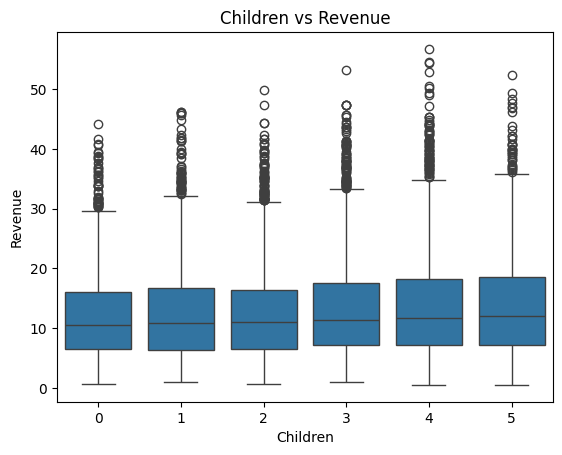

In [789]:
#bigger family size higher revenue
sns.boxplot(x='Children', y='Revenue', data=df)
plt.title('Children vs Revenue')
plt.show()


#### higher income higher revenue

Text(0.5, 1.0, 'Income vs Revenue')

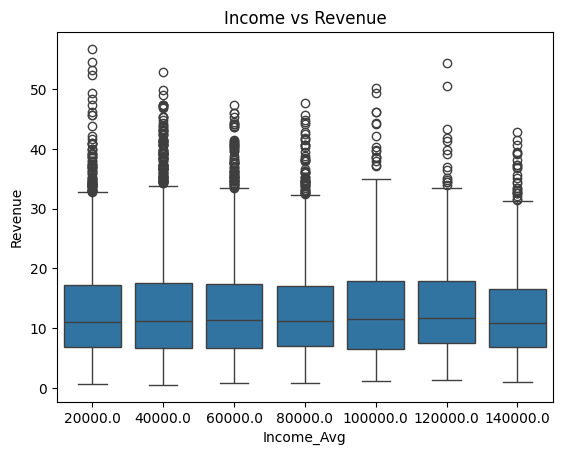

In [790]:
#higher income higher revenue
sns.boxplot(x='Income_Avg', y='Revenue', data=df)
plt.title('Income vs Revenue')

##### revenue distribution for each country

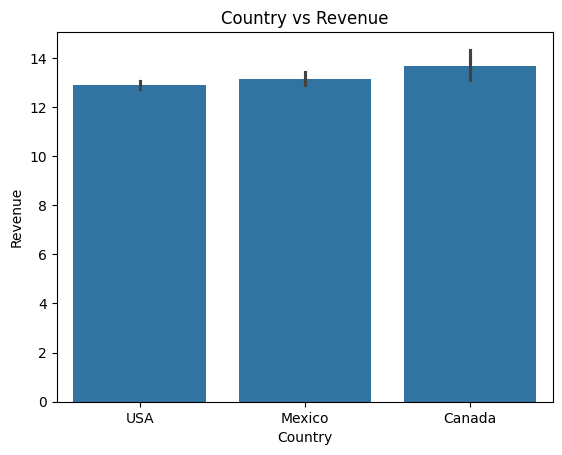

In [791]:
#revenue distribution for each country
sns.barplot(x='Country', y='Revenue', data=df)  
plt.title('Country vs Revenue')
plt.show()

##### units vs revenue

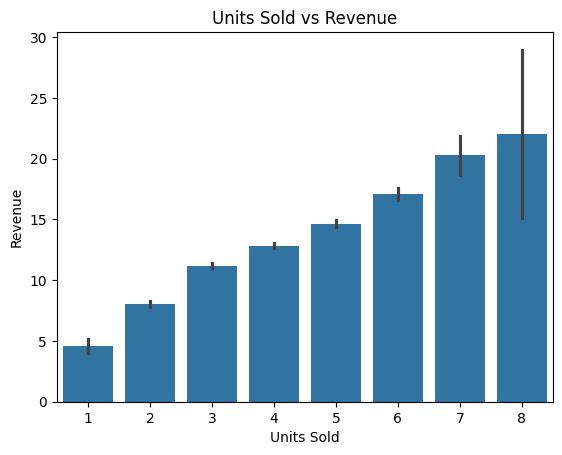

In [792]:
#units vs revenue
sns.barplot(x="Units Sold",y="Revenue" ,data=df)
plt.title('Units Sold vs Revenue')
plt.show()

#### product category distribution

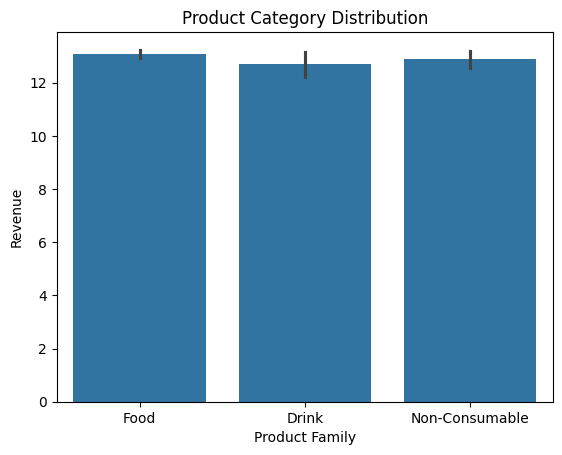

In [793]:
#product category distribution
sns.barplot(x='Product Family',y="Revenue" ,data=df)
plt.title('Product Category Distribution')
plt.show()

#### gender vs revenue

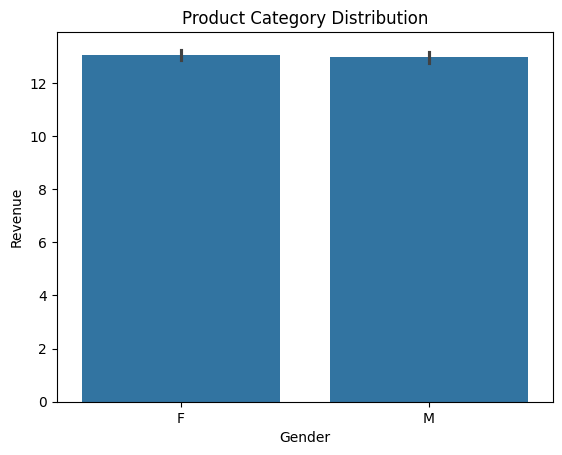

In [794]:

sns.barplot(x="Gender",y="Revenue" ,data=df)
plt.title('Product Category Distribution')
plt.show()

## Feature Engineering (RFM)

### Creating Features(Recency,Frequency,Monetary_value,Tenure)

In [795]:
rfm = summary_data_from_transaction_data(df, 'Customer ID', 'Purchase Date', monetary_value_col='Revenue', observation_period_end=df['Purchase Date'].max())
rfm = rfm.rename(columns={
    'frequency': 'frequency',
    'recency': 'recency',
    'T': 'T',
    'monetary_value': 'monetary_value'
})

count    5404.000000
mean        1.586603
std         2.278194
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        19.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 42.36 %


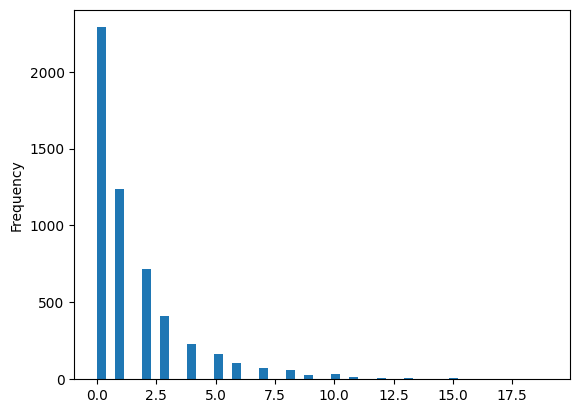

In [796]:
#Create histogram to find out how many customers purchased item only once.
rfm['frequency'].plot(kind='hist', bins=50)
print(rfm['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(rfm['frequency'] == 0)/float(len(rfm))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

### proving the Assumption to use Gamma-Gamma

In [797]:
#Check if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation.
rfm[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.480264
frequency,0.480264,1.000000


##  BG/NBD + Gamma-Gamma Modeling

In [798]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])

ggf = GammaGammaFitter(penalizer_coef=0.01)
rfm_monetary = rfm[rfm['monetary_value'] > 0].copy()
ggf.fit(rfm_monetary['frequency'], rfm_monetary['monetary_value'])

rfm_monetary['Expected_Avg_Profit'] = ggf.conditional_expected_average_profit(
    rfm_monetary['frequency'], rfm_monetary['monetary_value']
)

rfm_monetary['CLV_BGNBD'] = ggf.customer_lifetime_value(
    bgf,
    rfm_monetary['frequency'],
    rfm_monetary['recency'],
    rfm_monetary['T'],
    rfm_monetary['monetary_value'],
    time=3,
    discount_rate=0.01,
    freq='D'
)

rfm = rfm.merge(rfm_monetary[['CLV_BGNBD']], left_index=True, right_index=True, how='left')

## Statistical model parameters

In [799]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.732481,0.025177,0.683134,0.781828
alpha,142.871919,6.631328,129.874517,155.869321
a,0.116285,0.014839,0.087201,0.145368
b,0.578164,0.061173,0.458265,0.698062


In [800]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.898271,0.079595,3.742264,4.054278
q,1.559403,0.036305,1.488246,1.630560
v,3.517201,0.080595,3.359235,3.675166


## Hypothesis after Predicting clv (Statastical approach)

#### Higher the frequency higher the revenue

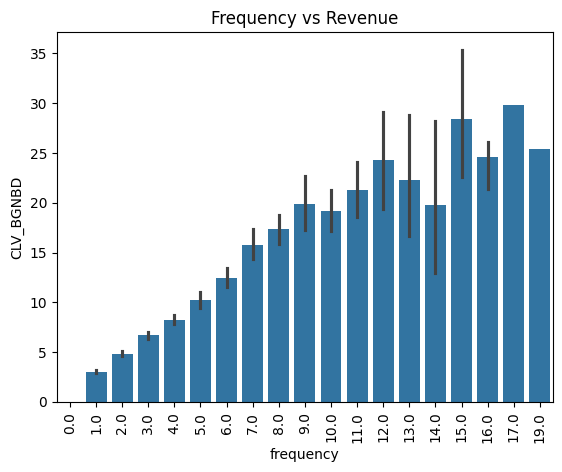

In [801]:
#Higher the frequency higher the revenue
sns.barplot(x='frequency', y='CLV_BGNBD', data=rfm)
plt.title('Frequency vs Revenue')
plt.xticks(rotation=90)
plt.show()


#### More recent higher the CLV 

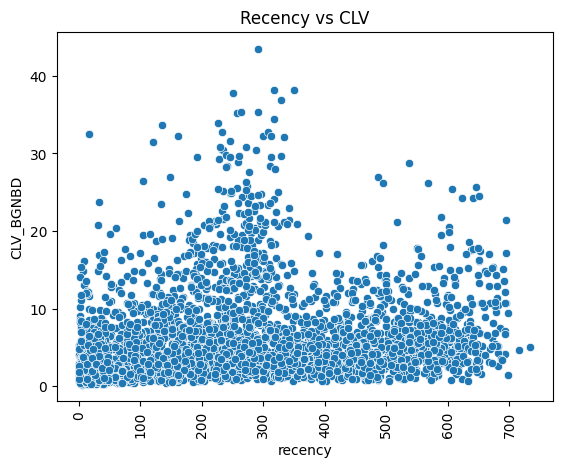

In [802]:
#More recent higher the CLV 
sns.scatterplot(x='recency', y='CLV_BGNBD', data=rfm)
plt.title('Recency vs CLV')
plt.xticks(rotation=90)
plt.show()

#### Longer the customer stays higher the CLV

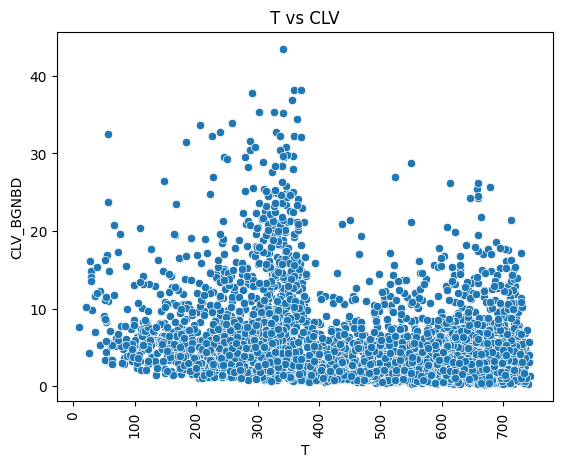

In [803]:
#Longer the customer stays higher the CLV
sns.scatterplot(x='T', y='CLV_BGNBD', data=rfm)
plt.title('T vs CLV')
plt.xticks(rotation=90)
plt.show()

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

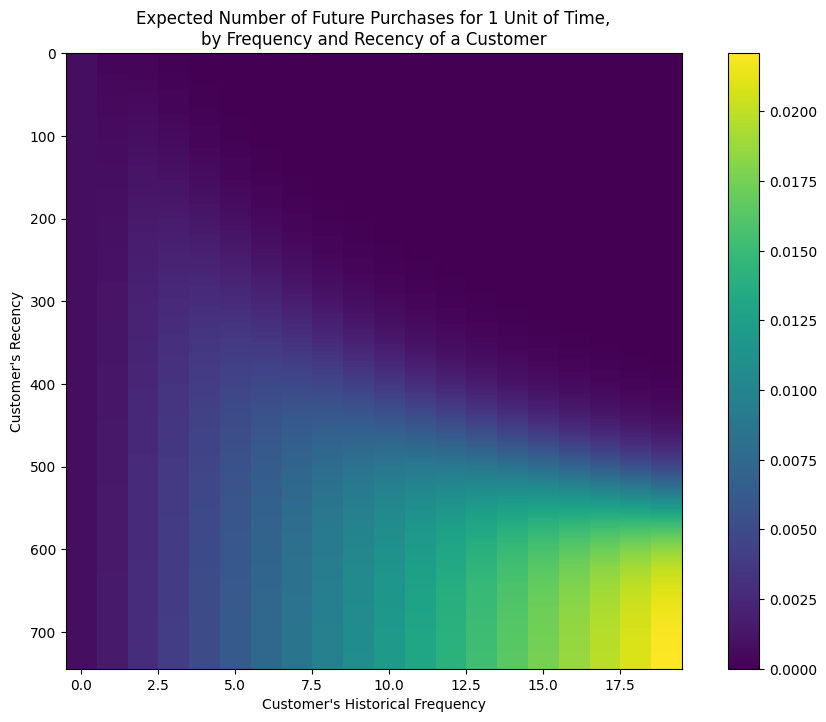

In [804]:
#Visualizing our frequency/recency matrix
%matplotlib inline
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

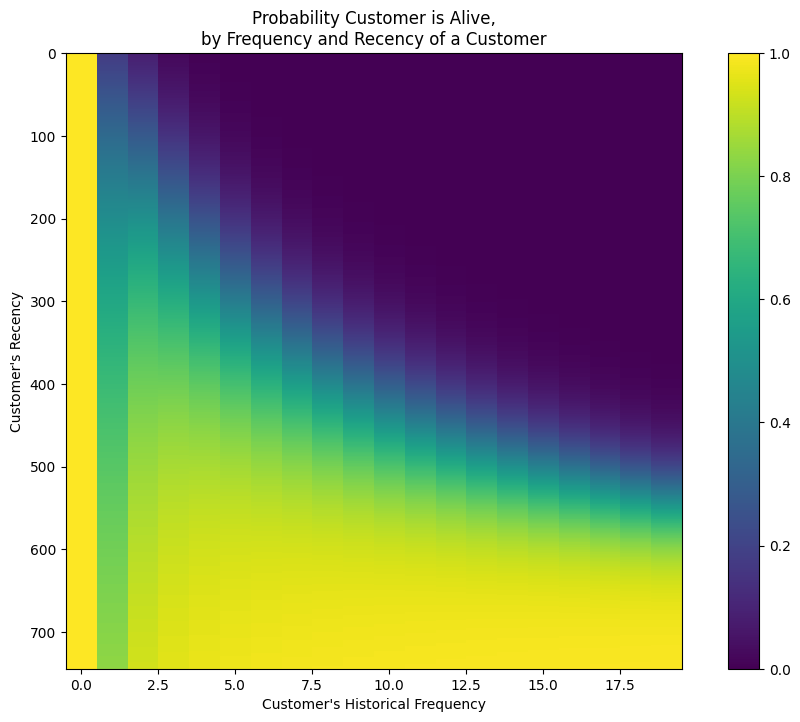

In [805]:
#predict if the customers are surely alive:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

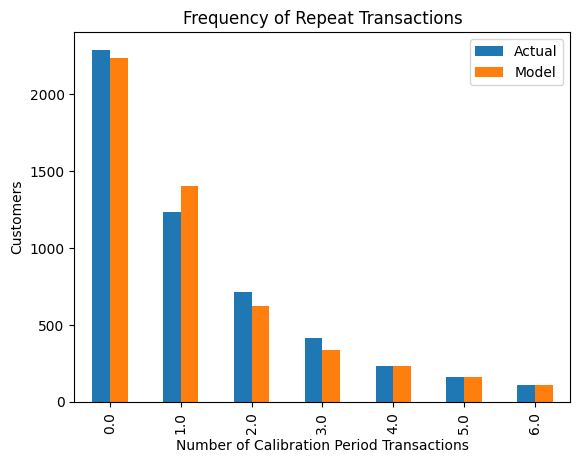

In [806]:
#Assessing model fit
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [807]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['Gender', 'Marital Status', 'Homeowner', 'Country']
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col])


In [808]:
df.head()

,Transaction,Purchase Date,Customer ID,Gender,Marital Status,Homeowner,Children,Annual Income,City,State or Province,Country,Product Family,Product Department,Product Category,Units Sold,Revenue,Income_Avg
0,1,2011-12-18,7223,0,1,1,2,$30K - $50K,Los Angeles,CA,2,Food,Snack Foods,Snack Foods,5,27.38,40000.0
1,2,2011-12-20,7841,1,0,1,5,$70K - $90K,Los Angeles,CA,2,Food,Produce,Vegetables,5,14.90,80000.0
2,3,2011-12-21,8374,0,0,0,2,$50K - $70K,Bremerton,WA,2,Food,Snack Foods,Snack Foods,3,5.52,60000.0
3,4,2011-12-21,9619,1,0,1,3,$30K - $50K,Portland,OR,2,Food,Snacks,Candy,4,4.44,40000.0
4,5,2011-12-22,1900,0,1,1,3,$130K - $150K,Beverly Hills,CA,2,Drink,Beverages,Carbonated Beverages,4,14.00,140000.0


In [809]:
features = df.groupby('Customer ID').agg({
    'Units Sold': 'sum',
    'Gender': 'first',
    'Marital Status': 'first',
    'Homeowner': 'first',
    'Country': 'first',
    'Children': 'first',
    'Income_Avg': 'first',
    'Revenue': 'sum'
}).reset_index()

xdata = rfm.reset_index().merge(features, on='Customer ID')

In [810]:
xdata.columns

Index(['Customer ID', 'frequency', 'recency', 'T', 'monetary_value',
       'CLV_BGNBD', 'Units Sold', 'Gender', 'Marital Status', 'Homeowner',
       'Country', 'Children', 'Income_Avg', 'Revenue'],
      dtype='object')

##  Heatmap

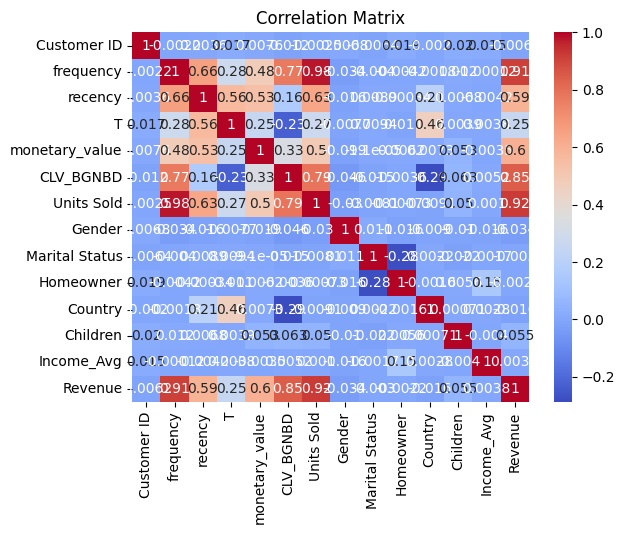

In [811]:
sns.heatmap(xdata.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

##  ML Models on BGNBD CLV

In [812]:
# Check for and drop rows with NaN in features or target
ml_data = xdata.drop(columns=['Customer ID'])
ml_data = ml_data.dropna(subset=['CLV_BGNBD'])  # if using hybrid CLV as target

X = ml_data.drop(columns=['CLV_BGNBD'])  # or the relevant CLV column
y = ml_data['CLV_BGNBD']

# Ensure all features are numeric
X = X.select_dtypes(include=[np.number])

# Final split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Linear Regression

Linear Regression Results
Mean Absolute Error: 1.4513181876251393
Mean Squared Error: 5.056344110274234
Root Mean Squared Error: 2.2486316083952556
R2 Score: 0.8584129099925678


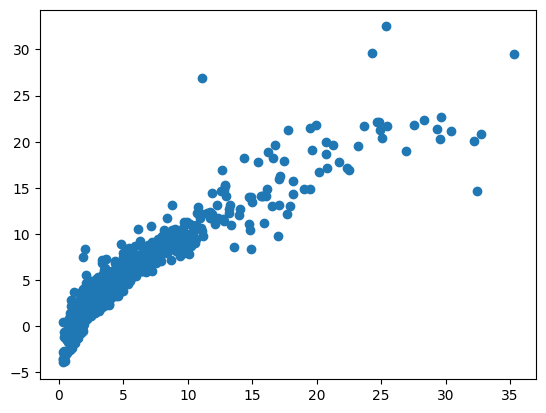

In [813]:
#linear regression 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  

import numpy as np
# from sklearn.model_selection import train_test_split
linear_model= LinearRegression()

# Replace NaN values with 0
# X_train = np.nan_to_num(X_train, nan=0.0)
# X_test = np.nan_to_num(X_test, nan=0.0)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
# Now you can fit the model without errors
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

print("Linear Regression Results")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)


### Decision tree

Decision Tree Regression Results
Mean Absolute Error: 1.07507543912304
Mean Squared Error: 4.466654606029643
Root Mean Squared Error: 2.113446144577534
R2 Score: 0.8749253187790396


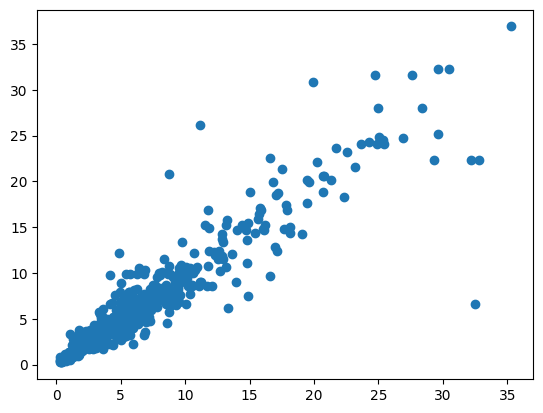

In [814]:
# decision tree regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
decision_pred = decision_tree_model.predict(X_test)
print("Decision Tree Regression Results")
print("Mean Absolute Error:", mean_absolute_error(y_test, decision_pred))
print("Mean Squared Error:", mean_squared_error(y_test, decision_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, decision_pred)))
print("R2 Score:", r2_score(y_test, decision_pred))
plt.scatter(y_test, decision_pred)

### XGBoost

In [815]:
xgb_model = xgb.XGBRegressor(n_estimators=200)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("XGBoost RMSE:", mean_squared_error(y_test, xgb_preds))
print("XGBoost R²:", r2_score(y_test, xgb_preds))


XGBoost RMSE: 1.631628454891976
XGBoost R²: 0.9543113522610018


### LightGBM

In [816]:
lgb_model = lgb.LGBMRegressor(n_estimators=200)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)
print("LightGBM RMSE:", mean_squared_error(y_test, lgb_preds))
print("LightGBM R²:", r2_score(y_test, lgb_preds))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1121
[LightGBM] [Info] Number of data points in the train set: 2492, number of used features: 12
[LightGBM] [Info] Start training from score 6.278617
LightGBM RMSE: 1.2462463207722505
LightGBM R²: 0.9651027726471247


### CatBoost

In [817]:
cat_model = CatBoostRegressor(verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
print("CatBoost RMSE:", mean_squared_error(y_test, cat_preds))
print("CatBoost R²:", r2_score(y_test, cat_preds))

CatBoost RMSE: 0.8282803251625649
CatBoost R²: 0.976806602083928


##  SHAP for XGBoost

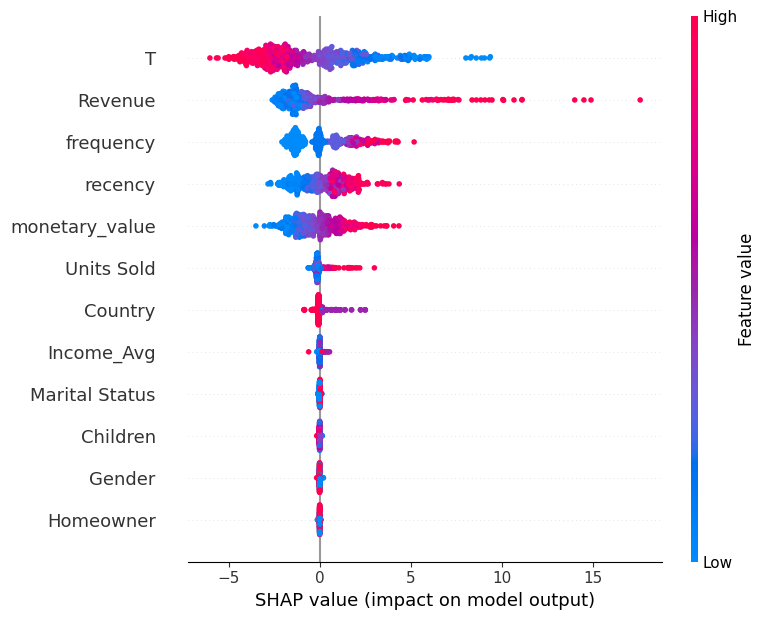

In [818]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

 97%|=================== | 606/623 [00:28<00:00]       

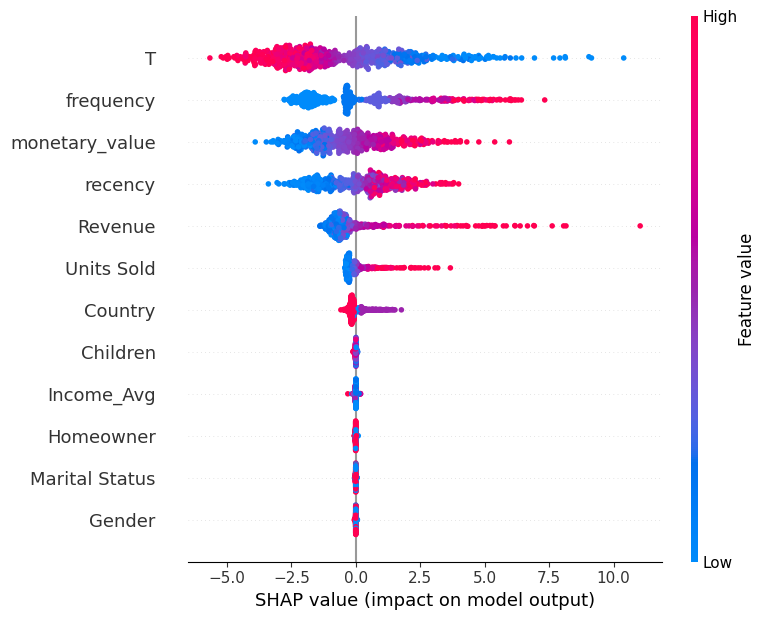

In [819]:
explainer = shap.Explainer(cat_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

### Features like Children and Income_Avg can be removed

## Feature Pruning

In [820]:
features = df.groupby('Customer ID').agg({
    'Units Sold': 'sum',
    'Revenue': 'sum'
}).reset_index()

xdata = rfm.reset_index().merge(features, on='Customer ID')

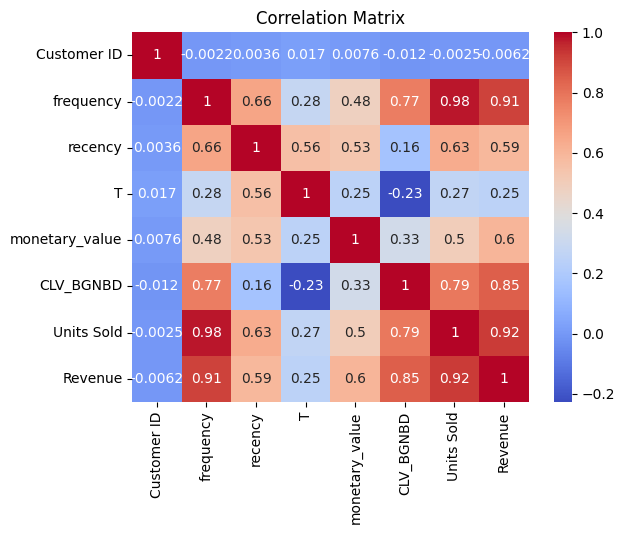

In [821]:
sns.heatmap(xdata.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

In [822]:
# Check for and drop rows with NaN in features or target
ml_data = xdata.drop(columns=['Customer ID'])
ml_data = ml_data.dropna(subset=['CLV_BGNBD'])  # if using hybrid CLV as target

X = ml_data.drop(columns=['CLV_BGNBD'])  # or the relevant CLV column
y = ml_data['CLV_BGNBD']

# Ensure all features are numeric
X = X.select_dtypes(include=[np.number])

# Final split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Linear Regression Results
Mean Absolute Error: 1.44433561971184
Mean Squared Error: 5.077768263865563
Root Mean Squared Error: 2.2533903931333255
R2 Score: 0.8578129936307235


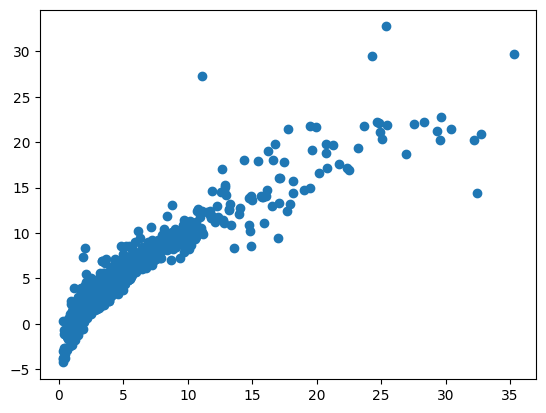

In [823]:
#linear regression 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  

import numpy as np
# from sklearn.model_selection import train_test_split
linear_model= LinearRegression()

# Replace NaN values with 0
# X_train = np.nan_to_num(X_train, nan=0.0)
# X_test = np.nan_to_num(X_test, nan=0.0)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
# Now you can fit the model without errors
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

print("Linear Regression Results")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)


Decision Tree Regression Results
Mean Absolute Error: 0.9861740758129942
Mean Squared Error: 3.7921446159691308
Root Mean Squared Error: 1.9473429631087409
R2 Score: 0.893812859775222


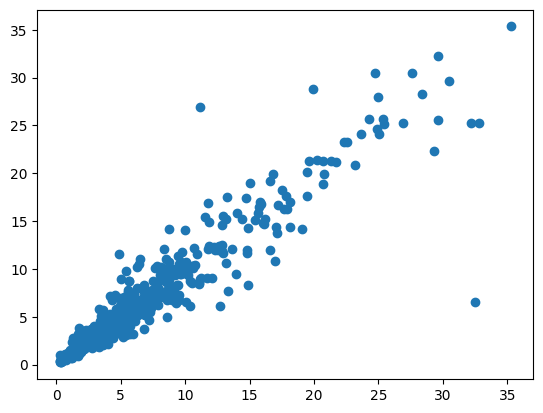

In [824]:
# decision tree regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
decision_pred = decision_tree_model.predict(X_test)
print("Decision Tree Regression Results")
print("Mean Absolute Error:", mean_absolute_error(y_test, decision_pred))
print("Mean Squared Error:", mean_squared_error(y_test, decision_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, decision_pred)))
print("R2 Score:", r2_score(y_test, decision_pred))
plt.scatter(y_test, decision_pred)

In [825]:
xgb_model = xgb.XGBRegressor(n_estimators=200)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("XGBoost RMSE:", mean_squared_error(y_test, xgb_preds))
print("XGBoost R²:", r2_score(y_test, xgb_preds))


XGBoost RMSE: 1.5175035636958925
XGBoost R²: 0.9575070626180233


In [826]:
lgb_model = lgb.LGBMRegressor(n_estimators=200)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)
print("LightGBM RMSE:", mean_squared_error(y_test, lgb_preds))
print("LightGBM R²:", r2_score(y_test, lgb_preds))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 2492, number of used features: 6
[LightGBM] [Info] Start training from score 6.278617
LightGBM RMSE: 1.15884660541279
LightGBM R²: 0.9675501281069874


In [827]:
cat_model = CatBoostRegressor(verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
print("CatBoost RMSE:", mean_squared_error(y_test, cat_preds))
print("CatBoost R²:", r2_score(y_test, cat_preds))

CatBoost RMSE: 0.7398237480289896
CatBoost R²: 0.9792835516497046


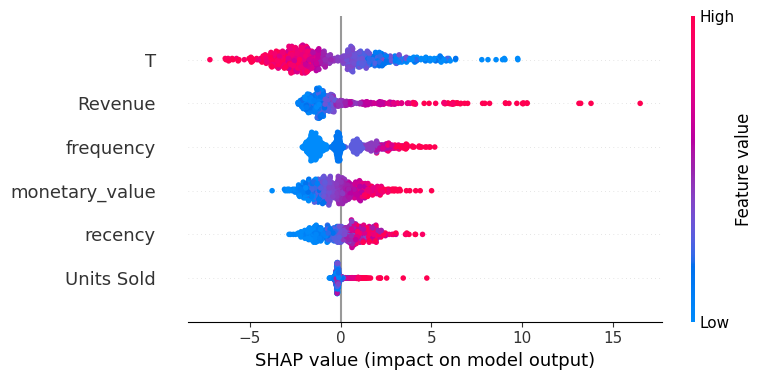

In [828]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

##  Compare All CLVs

In [829]:
# 1. Create X again for predictions, same preprocessing as during training
X_pred = xdata.drop(columns=['Customer ID', 'CLV_BGNBD'], errors='ignore')
X_pred = X_pred.select_dtypes(include=[np.number])
X_pred = X_pred.dropna()

# # 2. Predict
xgb_preds = xgb_model.predict(X_pred)
lgb_preds = lgb_model.predict(X_pred)
cat_preds = cat_model.predict(X_pred)
y_pred = linear_model.predict(X_pred)
decision_pred = decision_tree_model.predict(X_pred)

# 3. Assign predictions only to rows in xdata that match X_pred
xdata.loc[X_pred.index, 'CLV_Linear'] = y_pred
xdata.loc[X_pred.index, 'CLV_DecisionTree'] = decision_pred
xdata.loc[X_pred.index, 'CLV_XGBoost'] = xgb_preds
xdata.loc[X_pred.index, 'CLV_LightGBM'] = lgb_preds
xdata.loc[X_pred.index, 'CLV_CatBoost'] = cat_preds


Correlation between models and probabilistic CLV:
                   Customer ID  CLV_XGBoost  CLV_LightGBM  CLV_CatBoost  \
Customer ID           1.000000    -0.005649     -0.005713     -0.006510   
CLV_XGBoost          -0.005649     1.000000      0.997302      0.997909   
CLV_LightGBM         -0.005713     0.997302      1.000000      0.998125   
CLV_CatBoost         -0.006510     0.997909      0.998125      1.000000   
CLV_Probabilistic    -0.012291     0.995412      0.995335      0.997275   

                   CLV_Probabilistic  
Customer ID                -0.012291  
CLV_XGBoost                 0.995412  
CLV_LightGBM                0.995335  
CLV_CatBoost                0.997275  
CLV_Probabilistic           1.000000  


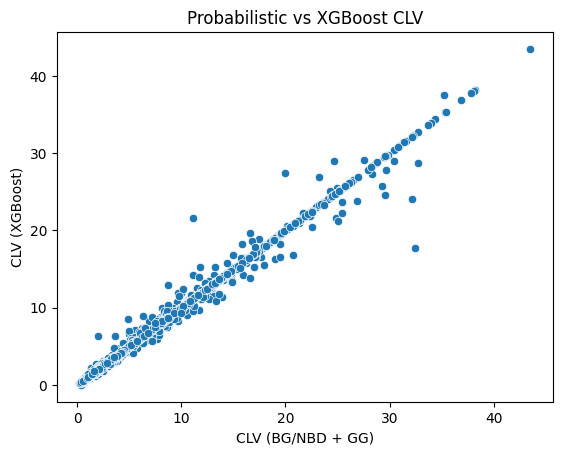

In [830]:
# Extract predictions from previous ML models if not already stored
comparison = xdata[['Customer ID', 'CLV_XGBoost', 'CLV_LightGBM', 'CLV_CatBoost']].copy()

# Merge with probabilistic CLV
comparison = comparison.merge(rfm[['CLV_BGNBD']], left_on='Customer ID', right_index=True)

# Rename for clarity
comparison = comparison.rename(columns={
    'CLV_BGNBD': 'CLV_Probabilistic'
})

# Correlation matrix
print("Correlation between models and probabilistic CLV:")
print(comparison.corr())

# Plot for XGBoost
sns.scatterplot(data=comparison, x='CLV_Probabilistic', y='CLV_XGBoost')
plt.title("Probabilistic vs XGBoost CLV")
plt.xlabel("CLV (BG/NBD + GG)")
plt.ylabel("CLV (XGBoost)")
plt.show()


In [831]:
from sklearn.cluster import KMeans

# Fill missing CLV with 0 before clustering
clv_for_cluster = xdata[['CLV_BGNBD']].fillna(0)

# 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
xdata['Segment'] = kmeans.fit_predict(clv_for_cluster)

# Map cluster numbers to meaningful names
cluster_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
xdata['Segment'] = xdata['Segment'].map(cluster_mapping)


##  Save Final CSV

In [832]:
xdata.to_csv("Final_Clv_All_Models.csv", index=False)
print("Saved: Final_Clv_All_Models.csv")

Saved: Final_Clv_All_Models.csv


In [833]:
# # Predict expected orders in next 90 days
# rfm['expected_orders_90D'] = bgf.conditional_expected_number_of_purchases_up_to_time(
#     90,  # future time window in days
#     rfm['frequency'],
#     rfm['recency'],
#     rfm['T']
# )


In [834]:
# # Expected average order value
# rfm['expected_aov'] = ggf.conditional_expected_average_profit(
#     rfm['frequency'],
#     rfm['monetary_value']
# )
# rfm['expected_revenue_90D'] = rfm['expected_orders_90D'] * rfm['expected_aov']

In [835]:
# # Merge all into a final table
# final = xdata.merge(
#     rfm[['expected_orders_90D', 'expected_aov', 'expected_revenue_90D']],
#     left_on='Customer ID',
#     right_index=True,
#     how='left'
# )

# # Save final comparison table
# final.to_csv("CLV_Full_Comparison.csv", index=False)
# print("Saved: CLV_Full_Comparison.csv")


 Error Summary Statistics:


,Abs_Error_XGBoost,Abs_Error_LightGBM,Abs_Error_CatBoost
count,3115.000000,3115.000000,3115.000000
mean,0.138280,0.218205,0.185051
std,0.534823,0.512912,0.384164
min,0.000003,0.000045,0.000012
25%,0.011631,0.050949,0.045462
50%,0.028380,0.112534,0.106007
75%,0.070326,0.218644,0.218810
max,14.768279,13.241292,12.308201


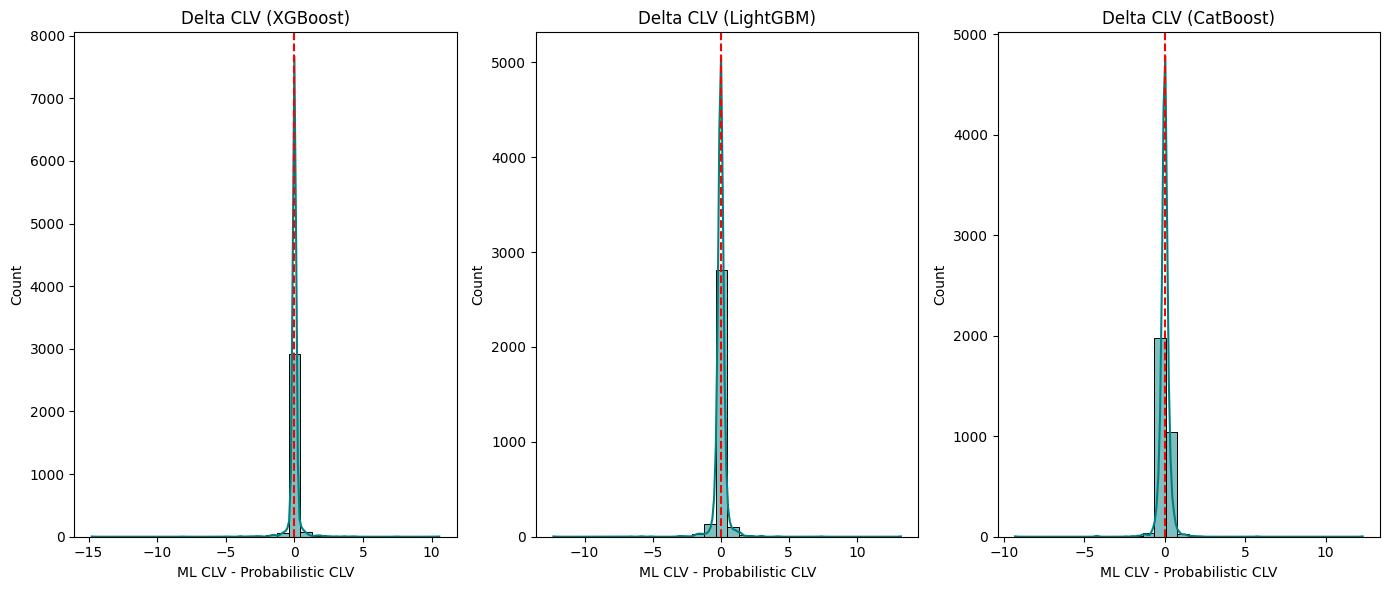

In [836]:
#  Step 1: Create delta (error) columns
comparison['Delta_XGBoost'] = comparison['CLV_XGBoost'] - comparison['CLV_Probabilistic']
comparison['Delta_LightGBM'] = comparison['CLV_LightGBM'] - comparison['CLV_Probabilistic']
comparison['Delta_CatBoost'] = comparison['CLV_CatBoost'] - comparison['CLV_Probabilistic']

#  Step 2: Calculate absolute error and percentage error
for model in ['XGBoost', 'LightGBM', 'CatBoost']:
    comparison[f'Abs_Error_{model}'] = comparison[f'Delta_{model}'].abs()

# Step 3: Summary statistics
summary = comparison[[col for col in comparison.columns if 'Error' in col]].describe()
print(" Error Summary Statistics:")
display(summary)

#  Step 4: Visualize delta distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
for i, model in enumerate(['XGBoost', 'LightGBM', 'CatBoost']):
    plt.subplot(1, 3, i+1)
    sns.histplot(comparison[f'Delta_{model}'], kde=True, bins=30, color='teal')
    plt.title(f'Delta CLV ({model})')
    plt.xlabel('ML CLV - Probabilistic CLV')
    plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()



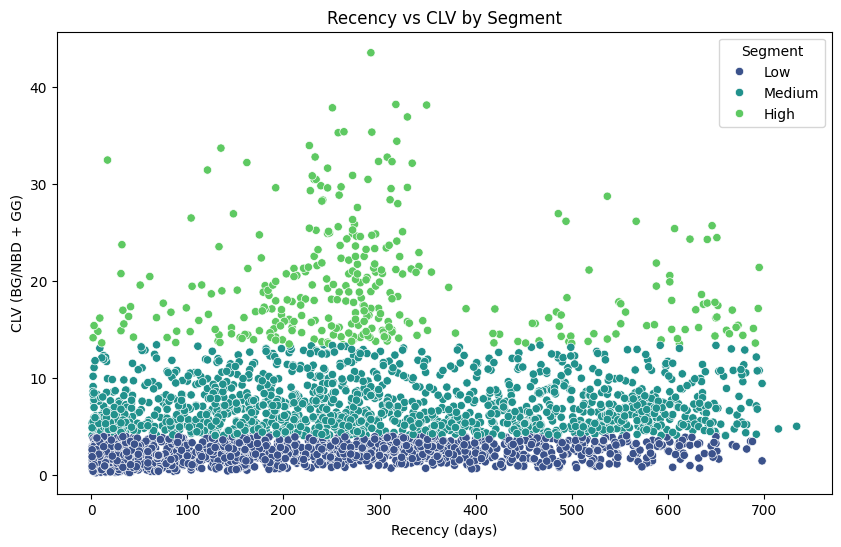

In [837]:
#scatter plot for recency vs segment
plt.figure(figsize=(10, 6))
sns.scatterplot(data=xdata, x='recency', y='CLV_BGNBD', hue='Segment', palette='viridis')
plt.title('Recency vs CLV by Segment')
plt.xlabel('Recency (days)')
plt.ylabel('CLV (BG/NBD + GG)')
plt.legend(title='Segment')
plt.show()

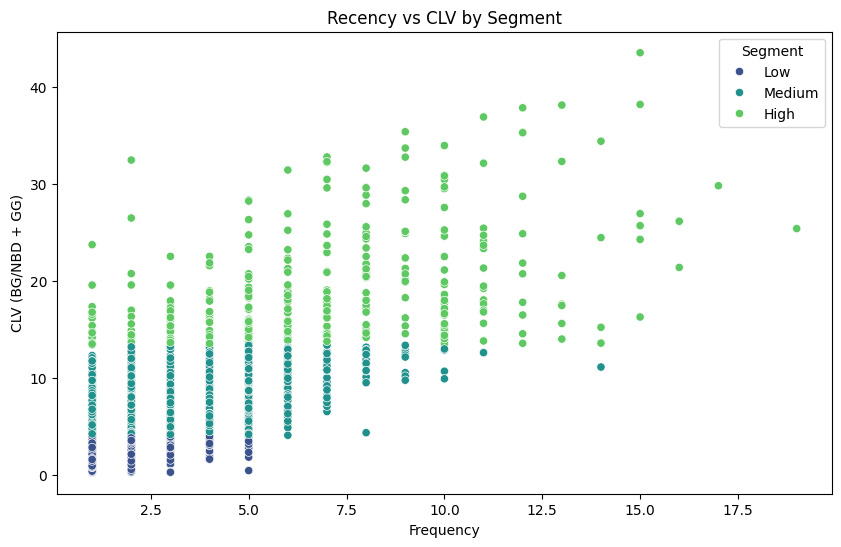

In [838]:
#scatter plot for recency vs segment
plt.figure(figsize=(10, 6))
sns.scatterplot(data=xdata, x='frequency', y='CLV_BGNBD', hue='Segment', palette='viridis')
plt.title('Recency vs CLV by Segment')
plt.xlabel('Frequency')
plt.ylabel('CLV (BG/NBD + GG)')
plt.legend(title='Segment')
plt.show()

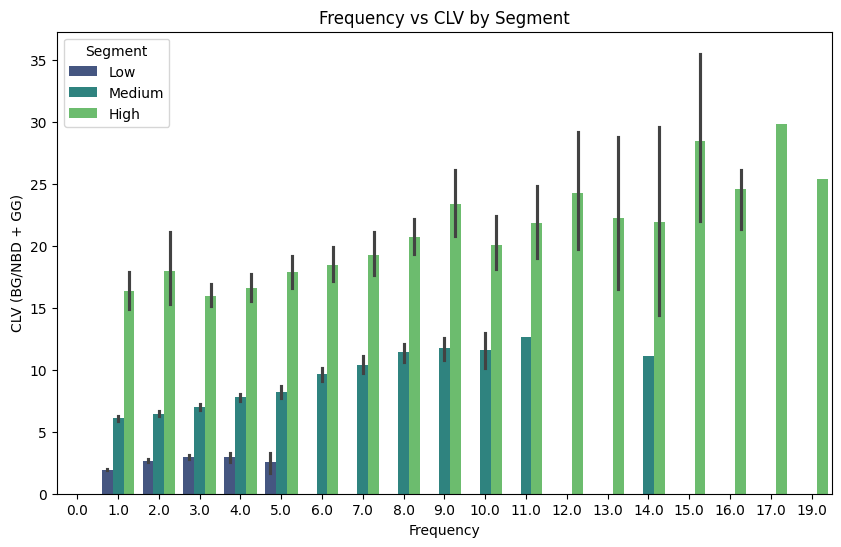

In [839]:
#scatter plot for recency vs segment
plt.figure(figsize=(10, 6))
sns.barplot(data=xdata, x='frequency', y='CLV_BGNBD', hue='Segment', palette='viridis')
plt.title('Frequency vs CLV by Segment')
plt.xlabel('Frequency')
plt.ylabel('CLV (BG/NBD + GG)')
plt.legend(title='Segment')
plt.show()

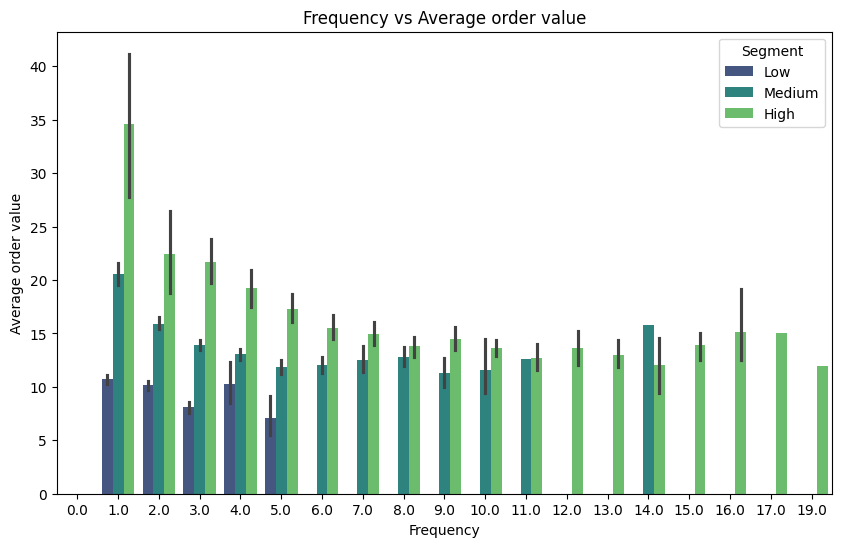

In [840]:
#scatter plot for recency vs segment
plt.figure(figsize=(10, 6))
sns.barplot(data=xdata, x='frequency', y='monetary_value', hue='Segment', palette='viridis')
plt.title('Frequency vs Average order value')
plt.xlabel('Frequency')
plt.ylabel('Average order value')
plt.legend(title='Segment')
plt.show()

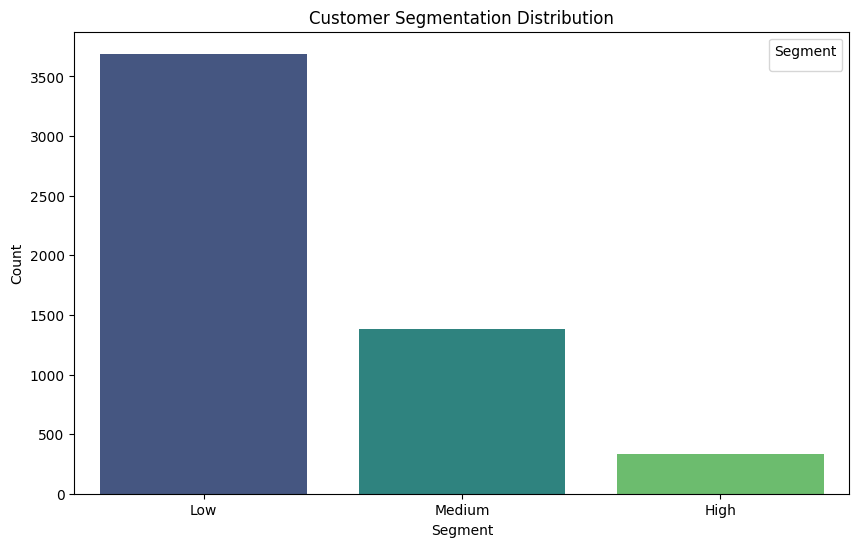

In [841]:

plt.figure(figsize=(10, 6))
sns.countplot(data=xdata, x='Segment', palette='viridis')
plt.title('Customer Segmentation Distribution')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.legend(title='Segment')
plt.show()


In [842]:
#sum up the clv_bgnbd
print(f'Total Predicted Revenue for next three months(Statastical):{xdata['CLV_BGNBD'].sum()}')
#sum up the clv_xgboost
print(f'Total Predicted Revenue for next three months(XGBoost):{xdata['CLV_XGBoost'].sum()}')
#sum up the clv_lightgbm
print(f'Total Predicted Revenue for next three months(LightGBM):{xdata['CLV_LightGBM'].sum()}')
#sum up the clv_catboost
print(f'Total Predicted Revenue for next three months(CatBoost):{xdata['CLV_CatBoost'].sum()}')
#sum up the clv_linear
print(f'Total Predicted Revenue for next three months(Linear):{xdata['CLV_Linear'].sum()}')
#sum up the clv_decision_tree
print(f'Total Predicted Revenue for next three months(DecisionTree):{xdata['CLV_DecisionTree'].sum()}')



Total Predicted Revenue for next three months(Statastical):19530.450872491125
Total Predicted Revenue for next three months(XGBoost):22272.556640625
Total Predicted Revenue for next three months(LightGBM):22038.078553318628
Total Predicted Revenue for next three months(CatBoost):22012.29972760489
Total Predicted Revenue for next three months(Linear):19088.96028762705
Total Predicted Revenue for next three months(DecisionTree):22196.23811724412


In [843]:
# #sum up the reveue of last three months
# xdata['Revenue'].sum()
# #sum up the units sold of last three mionths
# xdata['Units Sold'].sum()

last_3_months = df[df['Purchase Date']  >= pd.Timestamp('2013-10-01')]
# last_3_months = last_3_months[last_3_months['Purchase Date'] <= pd.Timestamp('2013-10-30')]

# Calculate total revenue from the last 3 months
total_revenue_last_3_months = last_3_months['Revenue'].sum()

print(f'Total Revenue from the last 3 months: {total_revenue_last_3_months}')


Total Revenue from the last 3 months: 25314.62


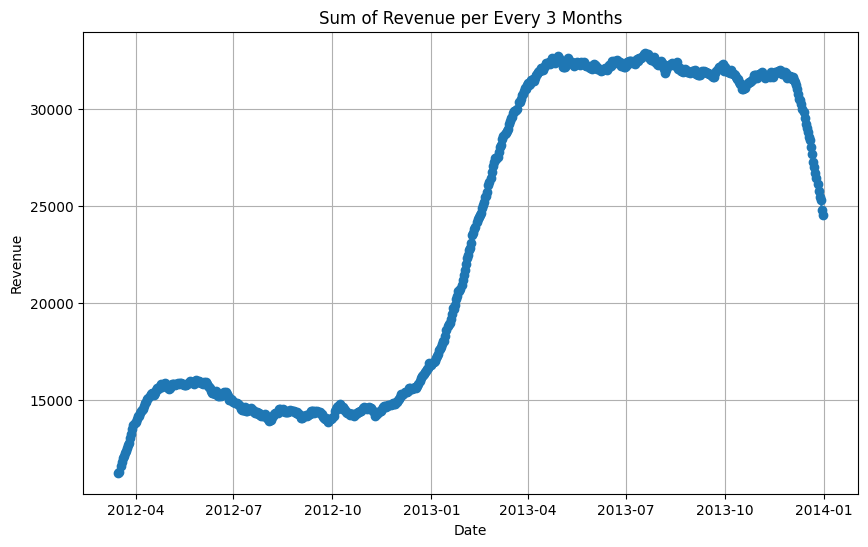

In [844]:
# # Calculate the rolling sum of revenue for every 3 months
# revenue_rolling_3_months = df['Revenue'].rolling('3M').sum()

# # Plot the line graph
# plt.figure(figsize=(10, 6))
# plt.plot(revenue_rolling_3_months.index, revenue_rolling_3_months.values, marker='o')
# plt.title('Sum of Revenue per Every 3 Months')
# plt.xlabel('Date')
# plt.ylabel('Revenue')
# plt.grid(True)
# plt.show()



# Ensure 'Purchase Date' is in datetime format
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

# Set 'Purchase Date' as the index
df.set_index('Purchase Date', inplace=True)

# Resample data to daily frequency and fill missing values with 0
data_daily = df.resample('D').sum()

# Calculate the rolling sum of revenue for every 90 days (3 months)
revenue_rolling_90_days = data_daily['Revenue'].rolling(window=90).sum()

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(revenue_rolling_90_days.index, revenue_rolling_90_days.values, marker='o')
plt.title('Sum of Revenue per Every 3 Months')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()
